<a href="https://colab.research.google.com/github/Adedoyin-Bamidele/Fatigue_detection/blob/main/CNN_fatige.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kagglehub  torch

In [2]:
import kagglehub

path = kagglehub.dataset_download("rihabkaci99/fatigue-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fatigue-dataset' dataset.
Path to dataset files: /kaggle/input/fatigue-dataset


In [3]:
import os
for root, dirs, files  in os.walk(path):
  print(root, len(files))

/kaggle/input/fatigue-dataset 0
/kaggle/input/fatigue-dataset/Data 0
/kaggle/input/fatigue-dataset/Data/Fatigue 1100
/kaggle/input/fatigue-dataset/Data/NonFatigue 1100


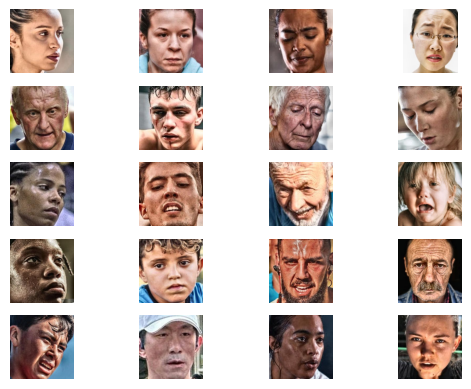

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms


path_1 = path + '/Data/Fatigue'

fatigue = os.listdir(path_1)[:20]

for name , label in enumerate(fatigue):
  img = Image.open(os.path.join(path_1, label))
  plt.subplot(5, 4, name+1)
  plt.axis('off')
  plt.imshow(img)

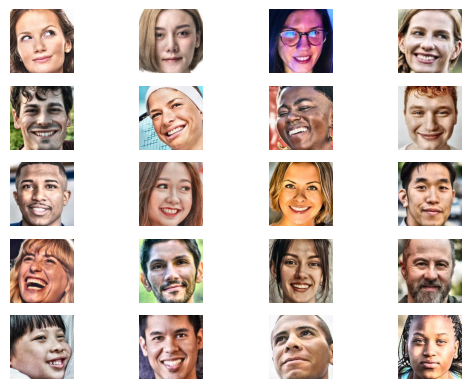

In [5]:
path_2 = path + '/Data/NonFatigue'

nonfatigue = os.listdir(path_2)[:20]

for i, img in enumerate(nonfatigue):
  image  = Image.open(os.path.join(path_2, img))
  plt.subplot(5, 4, i+1)
  plt.axis('off')
  plt.imshow(image)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
])

In [7]:
dataset= datasets.ImageFolder(path + '/Data')
train_dataset = datasets.ImageFolder(path + '/Data', transform=train_transform)
test_dataset = datasets.ImageFolder(path + '/Data', transform = test_transform)


train_set = int(0.8*len(dataset))
test_set = len(dataset) - train_set


train_index, test_index = random_split(range(len(dataset)), [train_set, test_set])

train,  test = Subset(train_dataset, train_index.indices), Subset(test_dataset, test_index.indices)

In [8]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

In [21]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

class FatigueCNN(nn.Module):
  def __init__(self, input_channels, output_channels, num_classes):
    super().__init__()
    layers=[]
    prev_ch = input_channels
    for next_ch in output_channels:
      layers.append(nn.Conv2d(prev_ch, next_ch,
                              kernel_size=3,
                              stride=1,
                              padding=1))
      layers.append(nn.ReLU())
      # Removed the redundant second MaxPool2d layer. One MaxPool2d per block is sufficient.
      layers.append(nn.MaxPool2d(kernel_size=3))
      prev_ch = next_ch

    self.conv = nn.Sequential(*layers)
    self.pool = nn.AdaptiveAvgPool2d((1,1))

    self.NN = nn.Sequential(
        nn.Flatten(),
        nn.Linear(output_channels[-1] * 1 * 1, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Dropout(0.6),
        nn.Linear(32, num_classes)
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.pool(x)
    x = self.NN(x)
    return x

In [10]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.9/609.9 kB 47.7 MB/s eta 0:00:00


In [22]:
def train(model, criterion, train_loader, optimizer):
  model.train()
  running_loss = 0.0
  correct= 0
  total = 0
  for batch, (X_batch, y_batch) in enumerate(train_loader):
    y_pred = model(X_batch)
    optimizer.zero_grad()
    loss = criterion(y_pred, y_batch.long())
    loss.backward()
    optimizer.step()

    running_loss +=  loss.item()
    _, predicted = y_pred.max(1)
    total += y_batch.size(0)
    correct += predicted.eq(y_batch).sum().item()
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct/total

    if batch % 100 ==0 and batch > 0:
      print(f'train_acc: {accuracy: .4f}% , train_loss: {avg_loss: .4f}')

In [23]:
def test(model, criterion, test_loader):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch , (X_test, y_test) in enumerate(test_loader):
      preds = model(X_test)
      loss = criterion(preds, y_test.long())

      running_loss += loss.item()
      _, predicted = preds.max(1)
      total += y_test.size(0)
      correct += predicted.eq(y_test).sum().item()
    avg_loss = running_loss/len(test_loader)
    accuracy = 100 *correct/total

    return accuracy

In [24]:
def objective(trial):
  n_layers = trial.suggest_int('n_layers', 1, 4)
  base_ch = trial.suggest_categorical('base_ch', [16, 32, 48,  64])
  channels_list = [int(base_ch * (2 ** i)) for i in range(n_layers)]
  lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  criterion = nn.CrossEntropyLoss()
  model = FatigueCNN(input_channels=3, output_channels=channels_list, num_classes=len(dataset.classes))

  optimizer = optim.Adam(model.parameters(), lr= lr)

  # Training loop within the objective function
  num_epochs = 5 # Reduced epochs for hyperparameter tuning efficiency
  for epoch in range(num_epochs):
      train(model, criterion, train_loader, optimizer)

  # Evaluate the model and return the accuracy
  accuracy = test(model, criterion, test_loader)
  return accuracy

In [25]:
study = optuna.create_study(direction="maximize" )
study.optimize(objective, n_trials=4, timeout=None)

[I 2025-12-06 07:33:57,841] A new study created in memory with name: no-name-ab6c44cd-3f69-4da4-9414-2aa0394bd3b4
[I 2025-12-06 07:38:02,960] Trial 0 finished with value: 68.63636363636364 and parameters: {'n_layers': 1, 'base_ch': 48, 'lr': 0.008184855744909472}. Best is trial 0 with value: 68.63636363636364.
[I 2025-12-06 07:44:39,055] Trial 1 finished with value: 61.36363636363637 and parameters: {'n_layers': 3, 'base_ch': 48, 'lr': 0.00010633944259992844}. Best is trial 0 with value: 68.63636363636364.
[I 2025-12-06 07:47:27,632] Trial 2 finished with value: 50.90909090909091 and parameters: {'n_layers': 4, 'base_ch': 16, 'lr': 0.0004545025377147523}. Best is trial 0 with value: 68.63636363636364.
[I 2025-12-06 07:50:07,935] Trial 3 finished with value: 64.0909090909091 and parameters: {'n_layers': 2, 'base_ch': 16, 'lr': 0.008635230627224232}. Best is trial 0 with value: 68.63636363636364.


In [26]:
best = study.best_params

{'n_layers': 1, 'base_ch': 48, 'lr': 0.008184855744909472}